# (24) mnist fit — ```conv```, amort

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [3]:
def _eval():
    seq_total = 1 if tr.model.cfg.seq_len == 1 else 1000
    results = tr.analysis('vld', seq_total=seq_total, n_data_batches=5, verbose=False)
    
    fig, axes = plot_convergence(results, color='C0', display=False)
    fig.suptitle(name, fontsize=16, fontfamily='monospace', color='darkgreen', y=1.1)
    display(fig)

In [4]:
dataset = 'MNIST'
model_type = 'poisson'
archi_type = 'conv|conv'

In [5]:
seq_lengths = [2, 4, 8]
beta_factors = [3/8, 1/2]
looper = itertools.product(
    seq_lengths,
    beta_factors,
)

name: <conv|conv>_(2,0.8)

poisson_MNIST_t-2_z-[64]_k-32_<conv|conv>
b200-ep400-lr(0.002)_beta(0.75:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_24,15:50)

epoch # 400, avg loss: 22.814405: 100%|█████| 400/400 [1:58:15<00:00, 17.74s/it]


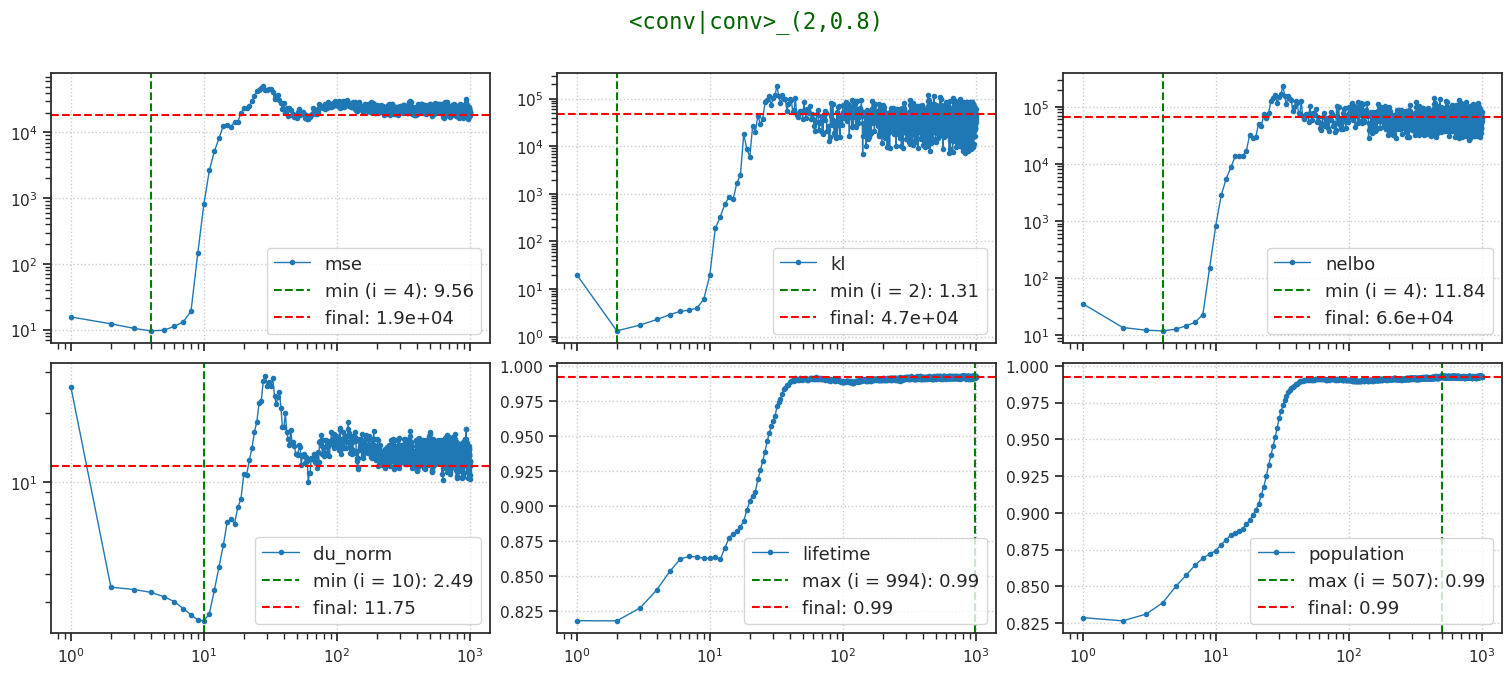

NotImplementedError: conv

name: <conv|conv>_(2,1.0)

poisson_MNIST_t-2_z-[64]_k-32_<conv|conv>
b200-ep400-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_24,19:21)

epoch # 400, avg loss: 22.710013: 100%|█████| 400/400 [2:00:54<00:00, 18.14s/it]


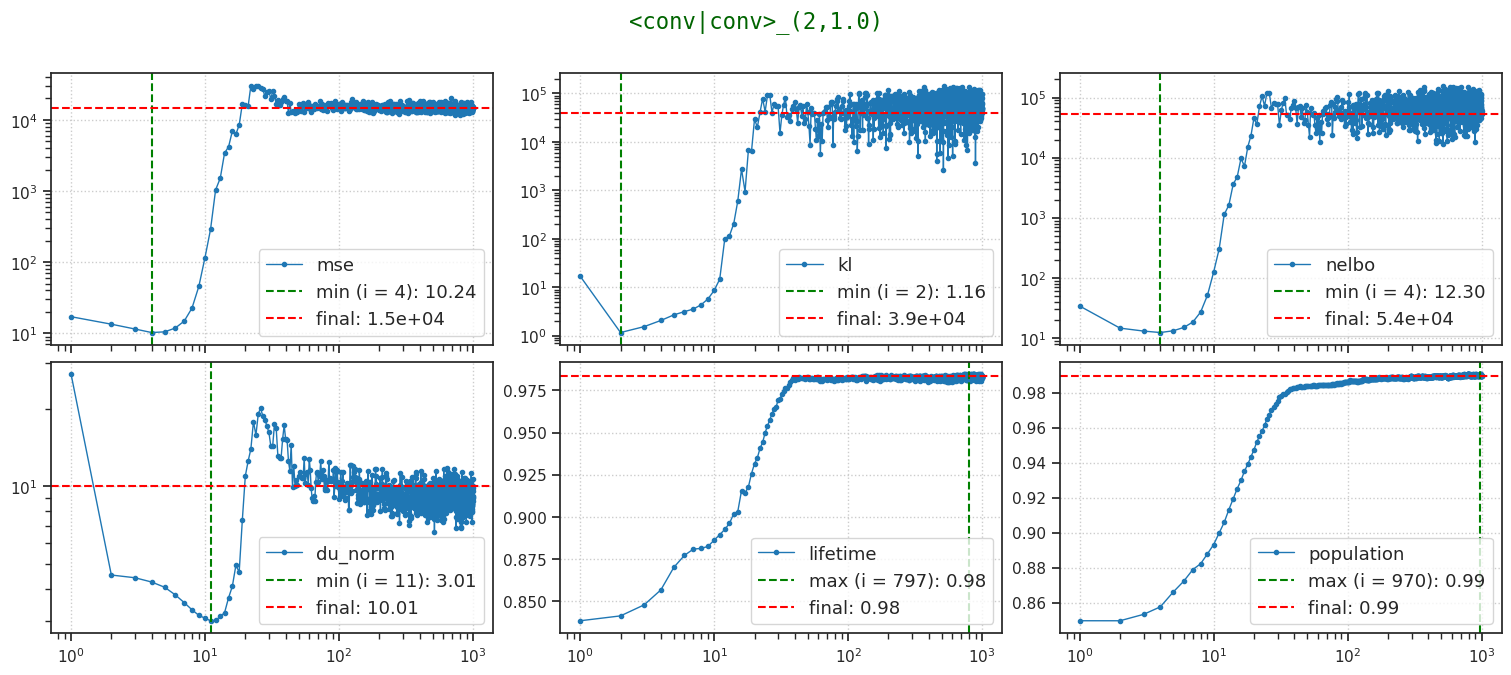

name: <conv|conv>_(4,1.5)

poisson_MNIST_t-4_z-[64]_k-32_<conv|conv>
b200-ep400-lr(0.002)_beta(1.5:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_24,21:23)

epoch # 400, avg loss: 15.804359: 100%|█████| 400/400 [3:51:35<00:00, 34.74s/it]


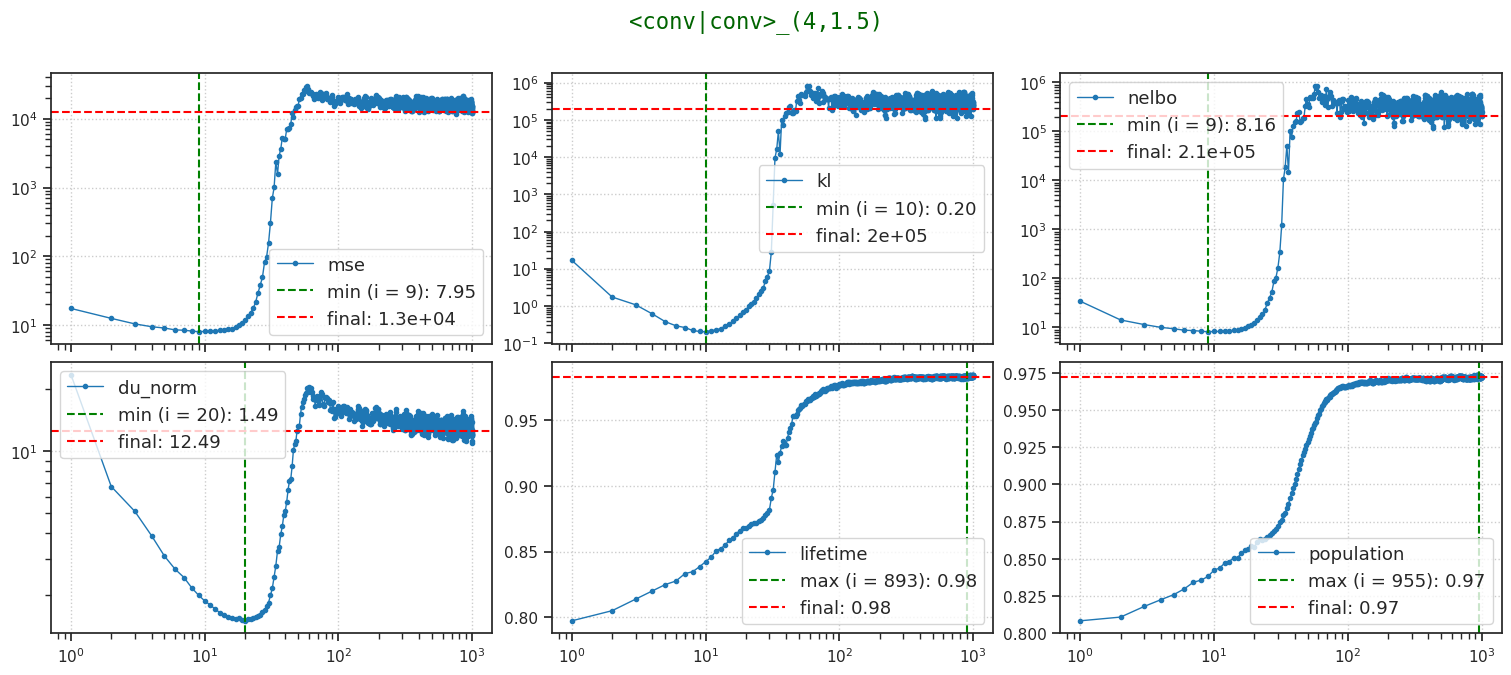

name: <conv|conv>_(4,2.0)

poisson_MNIST_t-4_z-[64]_k-32_<conv|conv>
b200-ep400-lr(0.002)_beta(2:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_25,01:16)

epoch # 400, avg loss: 16.704132: 100%|█████| 400/400 [3:22:46<00:00, 30.42s/it]


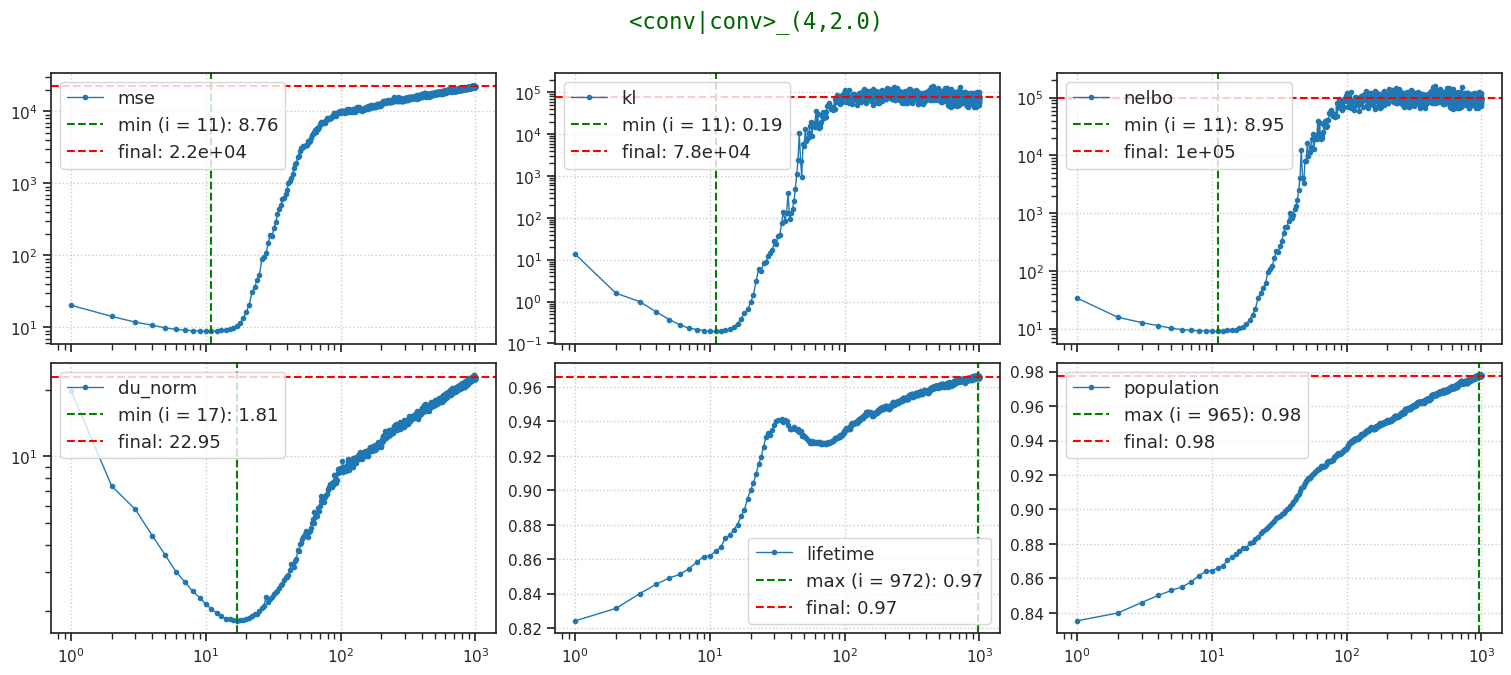

name: <conv|conv>_(8,3.0)

poisson_MNIST_t-8_z-[64]_k-32_<conv|conv>
b200-ep400-lr(0.002)_beta(3:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_25,04:40)

epoch # 400, avg loss: 11.712940: 100%|█████| 400/400 [6:26:33<00:00, 57.98s/it]


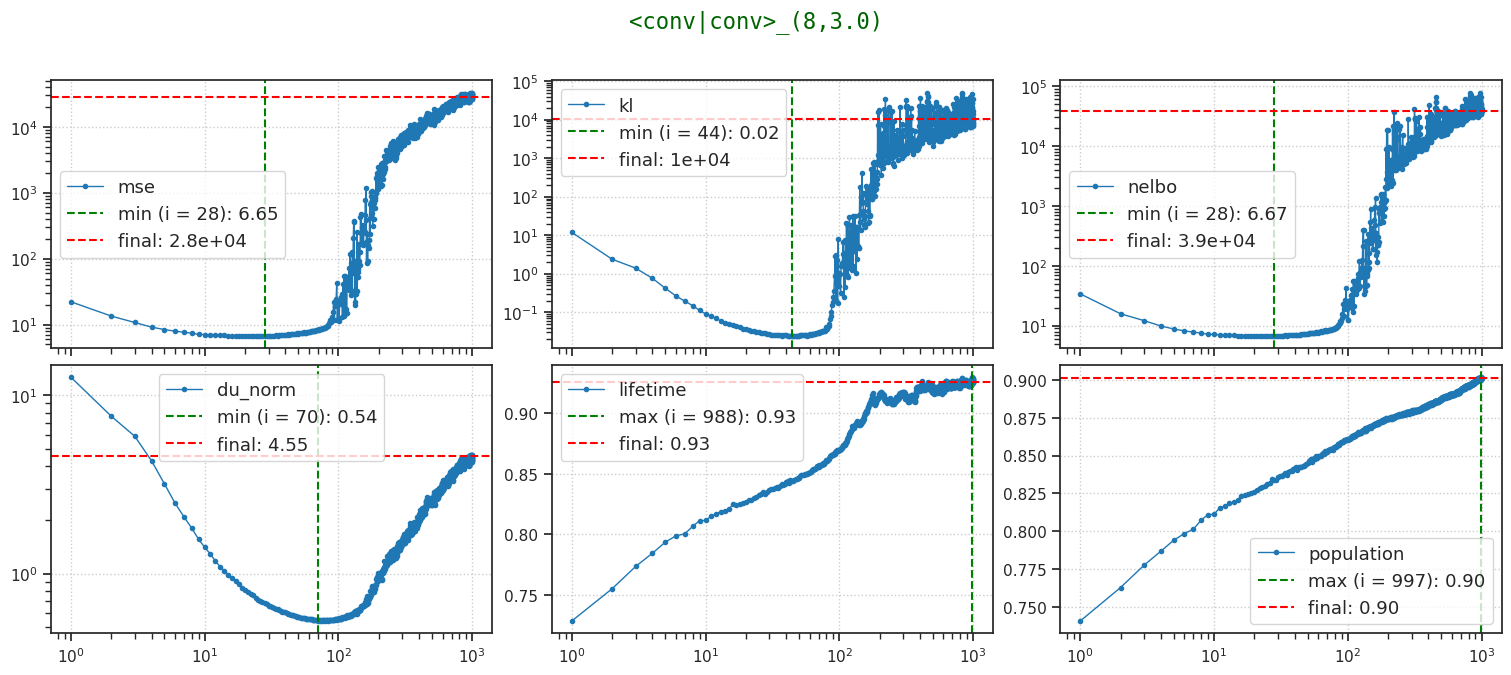

name: <conv|conv>_(8,4.0)

poisson_MNIST_t-8_z-[64]_k-32_<conv|conv>
b200-ep400-lr(0.002)_beta(4:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_25,11:08)

epoch # 400, avg loss: 12.709419: 100%|█████| 400/400 [6:27:07<00:00, 58.07s/it]


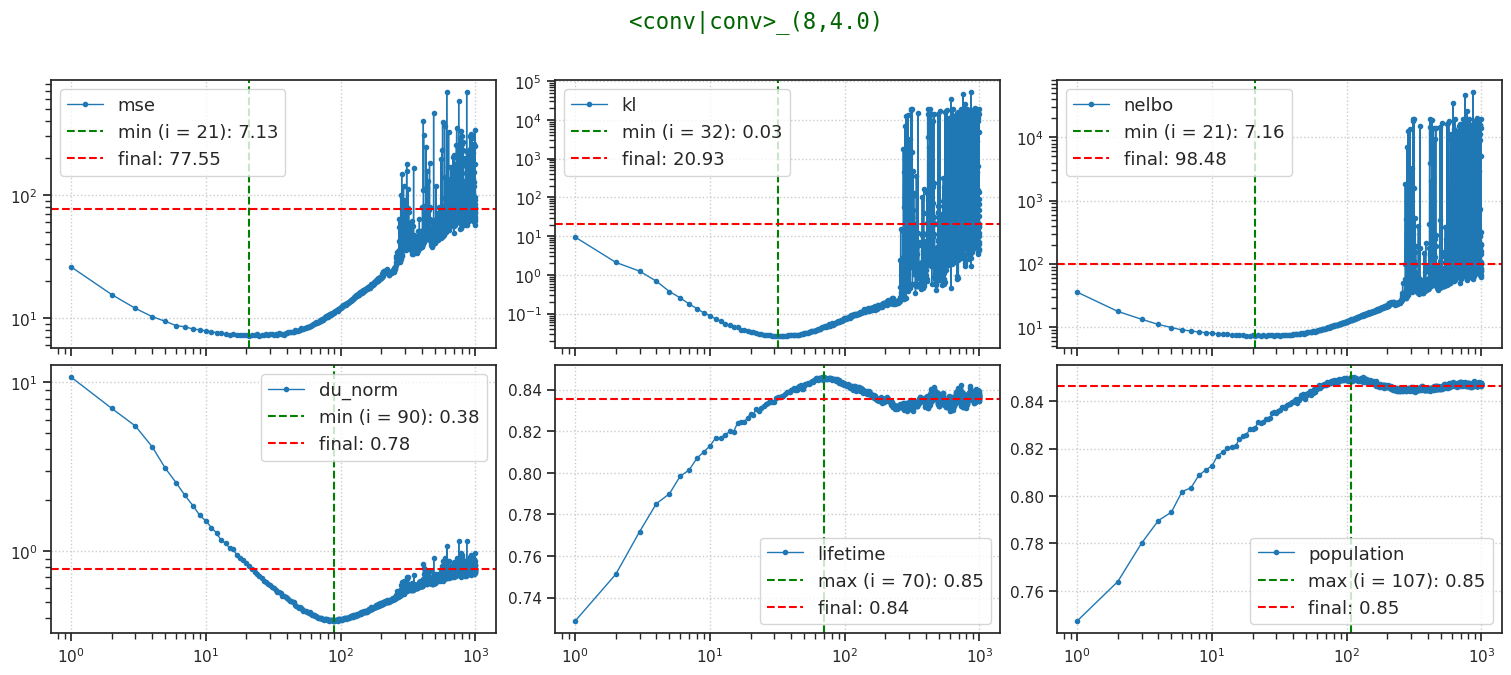

CPU times: user 1d 5h 44min 45s, sys: 1h 3min 25s, total: 1d 6h 48min 11s
Wall time: 22h 14min 45s


In [6]:
%%time


for seq_len, factor in looper:
    cfg_vae, cfg_tr = default_configs(
        dataset=dataset,
        model_type=model_type,
        archi_type=archi_type,
    )
    cfg_vae['seq_len'] = seq_len
    cfg_tr['kl_beta'] = factor * seq_len

    vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
    tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

    name = f"<{archi_type}>_({tr.model.cfg.seq_len},{tr.cfg.kl_beta:0.1f})"
    if name == '<conv|conv>_(2,0.8)':
        continue

    print(f"name: {name}\n\n{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n\n")

    tr.train()
    _eval()

In [7]:
print(tr.model.layer.dec)

Sequential(
  (0): UnFlatten()
  (1): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=256, out_features=16, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=16, out_features=256, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (2): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(
        (_layer): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (3): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (4): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(
        (_layer): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (5): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (6): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(
        (_layer): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=32, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (7): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_f